In [137]:
from utils import *
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [138]:
def word_counter(all_docs_of_a_class):
	d = {}
	for i in all_docs_of_a_class:
		for j in i:
			if j in d: d[j] += 1
			else: d[j] = 1
	
	return d

In [139]:
class NaiveBayes:
	def __init__(self, pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=True, compute_laplace=False, alpha=1):
		self.pos_train = pos_train
		self.neg_train = neg_train
		self.vocab = vocab
		self.prod_method = prod_method
		self.compute_laplace = compute_laplace
		self.alpha = alpha if compute_laplace else 0
		self.smallConst = smallConst if (prod_method == False and compute_laplace == False) else 0

		#Total number of documents in the training set
		self.train_len = len(pos_train) + len(neg_train)

		#Number of positive class docs and number of neg class docs
		self.pos_train_len = len(pos_train)
		self.neg_train_len = len(neg_train)

		#Probablity of pos class and probablity of neg class
		self.pr_pos = (self.pos_train_len) / self.train_len
		self.pr_neg = (self.neg_train_len) / self.train_len

		#Dictionaries of all the words (as key) and their corresponding frequencies (as value) of the pos and neg classes respectively
		self.word_freq_pos = word_counter(pos_train)
		self.word_freq_neg = word_counter(neg_train)

		#Number of occurrences (sum of freqs) of all words in pos and neg classes respectively
		self.sum_freqs_pos = sum(self.word_freq_pos.values())
		self.sum_freqs_neg = sum(self.word_freq_neg.values())

	#Probability of a word given a class
	def pr_wordK_given_class(self, word, cls):
		if cls == 'pos':
			n = self.word_freq_pos[word] if word in self.word_freq_pos else 0
			ret = (n + self.alpha) / (self.sum_freqs_pos + self.alpha*len(self.vocab))
		elif cls == 'neg': 
			n = self.word_freq_neg[word] if word in self.word_freq_neg else 0
			ret = (n + self.alpha) / (self.sum_freqs_neg + self.alpha*len(self.vocab))
		else: raise ValueError("Invalid class")
		
		return ret if ret != 0 else self.smallConst

	#Probability of a class given a document (using product of probabilities)
	def pr_class_given_doc_prod(self, cls, doc):
		pr = 1
		for word in doc:
			pr *= self.pr_wordK_given_class(word, cls)
		pr *= self.pr_pos if cls == 'pos' else self.pr_neg
		return pr

	#Probability of a class given a document (using log of probabilities)
	def pr_class_given_doc_log(self, cls, doc):
		pr = 0
		for word in doc:
			pr += math.log(self.pr_wordK_given_class(word, cls))
		pr += math.log(self.pr_pos) if cls == 'pos' else math.log(self.pr_neg)
		return pr

	#Classify a document
	def classify(self, doc):
		method_func = self.pr_class_given_doc_prod if self.prod_method else self.pr_class_given_doc_log
		pr_pos_given_doc = method_func('pos', doc)
		pr_neg_given_doc = method_func('neg', doc)
		if pr_pos_given_doc == pr_neg_given_doc: return random.choice(['pos', 'neg'])
		return 'pos' if pr_pos_given_doc > pr_neg_given_doc else 'neg'

## Q1

### Q1.1

Confusion matrix for the product of probabilities model
Accuracy: 0.5245098039215687
Precision: 0.5285657211346384
Recall: 0.5151869158878505
True Positives: 1323, False Negatives: 1245, False Positives: 1180, True Negatives: 1352


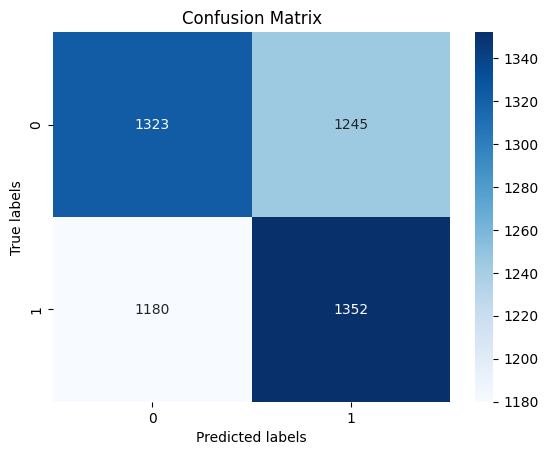

In [140]:
#Loading 20% positive and 20% negative instances from the training set and 20% positive and 20% negative instances from the test set
(pos_train, neg_train, vocab) = load_training_set(0.2, 0.2)
(pos_test,  neg_test) = load_test_set(0.2, 0.2)
# print(f"Length of pos_train: {len(pos_train)}, Length of neg_train: {len(neg_train)}, Length of vocab: {len(vocab)}")
# print(f"Length of pos_test: {len(pos_test)}, Length of neg_test: {len(neg_test)}")


#First analyzing the models performance when classification is done using the product of probabilities
product_naive_bayes = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=True, compute_laplace=False, alpha=0)

pos_class_predictions = [product_naive_bayes.classify(doc) for doc in pos_test]
neg_class_predictions = [product_naive_bayes.classify(doc) for doc in neg_test]

true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
predicted_labels = pos_class_predictions + neg_class_predictions
total_predictions = len(pos_test) + len(neg_test)

true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])

accuracy = (true_pos + true_neg) / total_predictions
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

#The confusion matrix for the product of probabilities model
print("Confusion matrix for the product of probabilities model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

conf_mat = np.array([np.array([true_pos, false_neg]), np.array([false_pos, true_neg])])
print(f'True Positives: {true_pos}, False Negatives: {false_neg}, False Positives: {false_pos}, True Negatives: {true_neg}')

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Q1-1.png')
plt.show()


### Q1.2

Confusion matrix for the log of probabilities model
Accuracy: 0.7523529411764706
Precision: 0.7758985200845666
Recall: 0.714563862928349
True Positives: 1835, False Negatives: 733, False Positives: 530, True Negatives: 2002


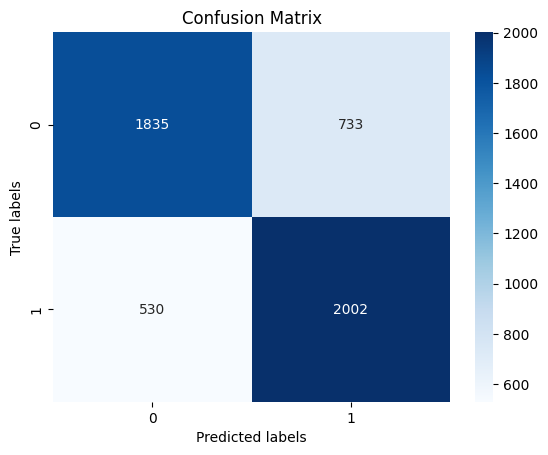

In [141]:
# #Now analyzing the models performance when classification is done using the log of probabilities
log_naive_bayes = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=False, compute_laplace=False, alpha=0)

pos_class_predictions = [log_naive_bayes.classify(doc) for doc in pos_test]
neg_class_predictions = [log_naive_bayes.classify(doc) for doc in neg_test]

true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
predicted_labels = pos_class_predictions + neg_class_predictions
total_predictions = len(pos_test) + len(neg_test)

true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])

accuracy = (true_pos + true_neg) / total_predictions
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

#The confusion matrix for the log of probabilities model
print("Confusion matrix for the log of probabilities model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

conf_mat = np.array([np.array([true_pos, false_neg]), np.array([false_pos, true_neg])])
print(f'True Positives: {true_pos}, False Negatives: {false_neg}, False Positives: {false_pos}, True Negatives: {true_neg}')

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Q1-2.png')
plt.show()


## Q2

Confusion matrix for the alpha = 1 model
Accuracy: 0.8060174188440221
Precision: 0.8501971090670171
Recall: 0.7526172935246219
True Positives: 1941, False Negatives: 638, False Positives: 342, True Negatives: 2131


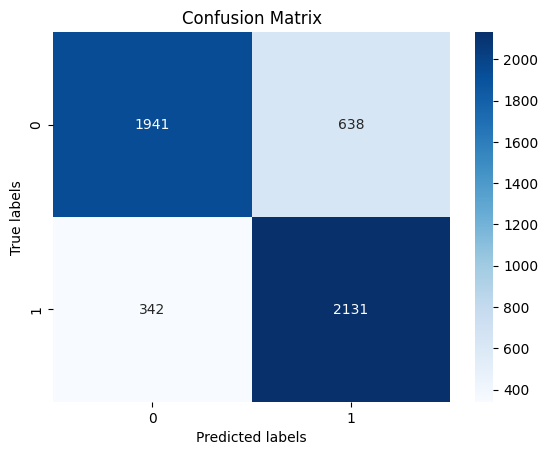

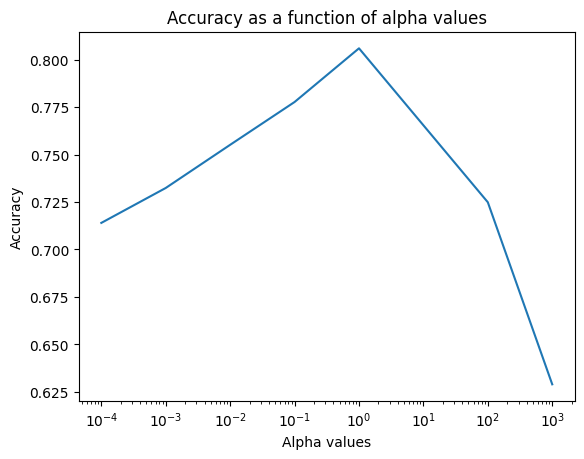

In [142]:
#First showing the confusion matrix, precision, recall, and accuracy of the classifier when evaluated on the test set when using alpha = 1
(pos_train, neg_train, vocab) = load_training_set(0.2, 0.2)
(pos_test,  neg_test) = load_test_set(0.2, 0.2)
# print(f"Length of pos_train: {len(pos_train)}, Length of neg_train: {len(neg_train)}, Length of vocab: {len(vocab)}")
# print(f"Length of pos_test: {len(pos_test)}, Length of neg_test: {len(neg_test)}")

naive_bayes_alpha_1 = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=False, compute_laplace=True, alpha=1)
pos_class_predictions = [naive_bayes_alpha_1.classify(doc) for doc in pos_test]
neg_class_predictions = [naive_bayes_alpha_1.classify(doc) for doc in neg_test]

true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
predicted_labels = pos_class_predictions + neg_class_predictions
total_predictions = len(pos_test) + len(neg_test)

true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])

accuracy = (true_pos + true_neg) / total_predictions
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print("Confusion matrix for the alpha = 1 model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

conf_mat = np.array([np.array([true_pos, false_neg]), np.array([false_pos, true_neg])])
print(f'True Positives: {true_pos}, False Negatives: {false_neg}, False Positives: {false_pos}, True Negatives: {true_neg}')

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Q2-1.png')
plt.show()


#Now varying the value of alpha from 0.0001 to 1000, by multiplying alpha with 10 each time
alpha_vals = [0.0001, 0.001, 0.01, 0.1, 1.0, 100, 1000]
accuracy_arr = []

for alpha in alpha_vals:
	naive_bayes_laplace = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=False, compute_laplace=True, alpha=alpha)
	pos_class_predictions = [naive_bayes_laplace.classify(doc) for doc in pos_test]
	neg_class_predictions = [naive_bayes_laplace.classify(doc) for doc in neg_test]

	true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
	predicted_labels = pos_class_predictions + neg_class_predictions
	total_predictions = len(pos_test) + len(neg_test)

	true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
	true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
	false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
	false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])

	accuracy = (true_pos + true_neg) / total_predictions
	accuracy_arr.append(accuracy)

plt.plot(alpha_vals, accuracy_arr)
plt.xscale('log')
plt.xlabel('Alpha values')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of alpha values')
plt.savefig('Q2-2.png')
plt.show()


## Q3

Confusion matrix for the full data model
Accuracy: 0.82348
Precision: 0.8665578823316109
Recall: 0.76472
True Positives: 9559, False Negatives: 2941, False Positives: 1472, True Negatives: 11028


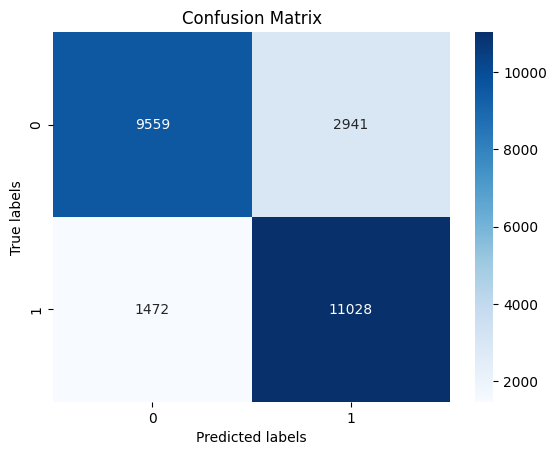

In [143]:
best_alpha = alpha_vals[accuracy_arr.index(max(accuracy_arr))]

#Uncomment the two lines below when done, they are commented as of now as they take long time to run, as they take a long time to run
(pos_train, neg_train, vocab) = load_training_set(1, 1)
(pos_test,  neg_test) = load_test_set(1, 1)
# print(f"Length of pos_train: {len(pos_train)}, Length of neg_train: {len(neg_train)}, Length of vocab: {len(vocab)}")
# print(f"Length of pos_test: {len(pos_test)}, Length of neg_test: {len(neg_test)}")

naive_bayes_full_data = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=False, compute_laplace=True, alpha=best_alpha)
pos_class_predictions = [naive_bayes_full_data.classify(doc) for doc in pos_test]
neg_class_predictions = [naive_bayes_full_data.classify(doc) for doc in neg_test]

true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
predicted_labels = pos_class_predictions + neg_class_predictions
total_predictions = len(pos_test) + len(neg_test)

true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])

accuracy = (true_pos + true_neg) / total_predictions
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print("Confusion matrix for the full data model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

conf_mat = np.array([np.array([true_pos, false_neg]), np.array([false_pos, true_neg])])
print(f'True Positives: {true_pos}, False Negatives: {false_neg}, False Positives: {false_pos}, True Negatives: {true_neg}')

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Q3.png')
plt.show()

## Q4

Confusion matrix for the half data model
Accuracy: 0.82512
Precision: 0.8639620275837363
Recall: 0.77176
True Positives: 9647, False Negatives: 2853, False Positives: 1519, True Negatives: 10981


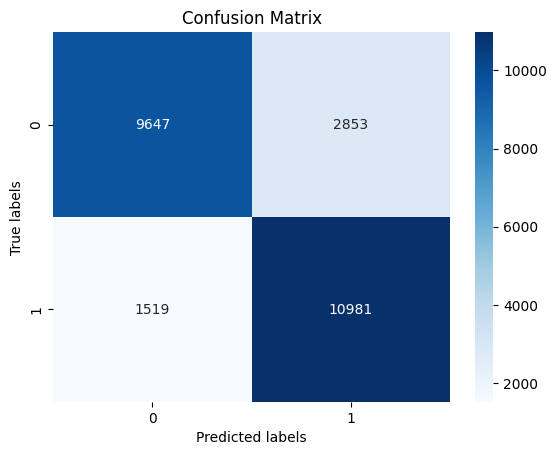

In [144]:
(pos_train, neg_train, vocab) = load_training_set(0.5, 0.5)
(pos_test,  neg_test) = load_test_set(1, 1)
# print(f"Length of pos_train: {len(pos_train)}, Length of neg_train: {len(neg_train)}, Length of vocab: {len(vocab)}")
# print(f"Length of pos_test: {len(pos_test)}, Length of neg_test: {len(neg_test)}")

naive_bayes_half_data = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=False, compute_laplace=True, alpha=best_alpha)
pos_class_predictions = [naive_bayes_half_data.classify(doc) for doc in pos_test]
neg_class_predictions = [naive_bayes_half_data.classify(doc) for doc in neg_test]

true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
predicted_labels = pos_class_predictions + neg_class_predictions
total_predictions = len(pos_test) + len(neg_test)

true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])

accuracy = (true_pos + true_neg) / total_predictions
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print("Confusion matrix for the half data model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

conf_mat = np.array([np.array([true_pos, false_neg]), np.array([false_pos, true_neg])])
print(f'True Positives: {true_pos}, False Negatives: {false_neg}, False Positives: {false_pos}, True Negatives: {true_neg}')

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Q4.png')
plt.show()

## Q6

Confusion matrix for the unbalanced data model
Accuracy: 0.66328
Precision: 0.8809257185516984
Recall: 0.3776
True Positives: 4720, False Negatives: 7780, False Positives: 638, True Negatives: 11862
[[ 4720  7780]
 [  638 11862]]


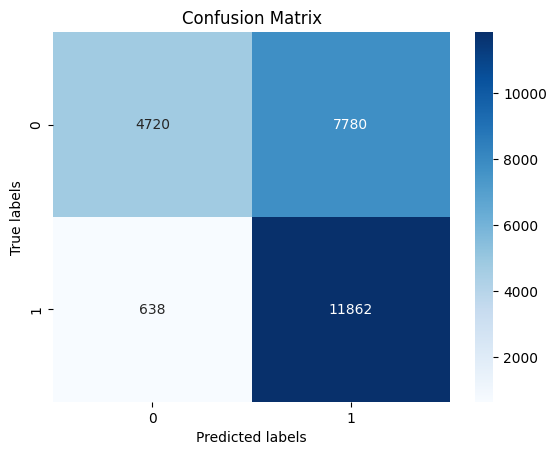

'Finished!'

In [145]:
(pos_train, neg_train, vocab) = load_training_set(0.1, 0.5)
(pos_test,  neg_test) = load_test_set(1, 1)
# print(f"Length of pos_train: {len(pos_train)}, Length of neg_train: {len(neg_train)}, Length of vocab: {len(vocab)}")
# print(f"Length of pos_test: {len(pos_test)}, Length of neg_test: {len(neg_test)}")

naive_bayes_unbalanced_data = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=False, compute_laplace=True, alpha=1)
pos_class_predictions = [naive_bayes_unbalanced_data.classify(doc) for doc in pos_test]
neg_class_predictions = [naive_bayes_unbalanced_data.classify(doc) for doc in neg_test]

true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
predicted_labels = pos_class_predictions + neg_class_predictions
total_predictions = len(pos_test) + len(neg_test)

true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])


accuracy = (true_pos + true_neg) / total_predictions
precision = true_pos / (true_pos + false_pos) if true_pos + false_pos != 0 else 0
recall = true_pos / (true_pos + false_neg) if true_pos + false_neg != 0 else 0

print("Confusion matrix for the unbalanced data model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# conf_mat = confusion_matrix(true_labels, predicted_labels)
conf_mat = np.array([np.array([true_pos, false_neg]), np.array([false_pos, true_neg])])
print(f'True Positives: {true_pos}, False Negatives: {false_neg}, False Positives: {false_pos}, True Negatives: {true_neg}')
print(conf_mat)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Q6.png')
plt.show()

"""Finished!"""

### Below is the confusion matrix for alpha = 10

Length of pos_train: 1276, Length of neg_train: 6295, Length of vocab: 50725
Length of pos_test: 12500, Length of neg_test: 12500
True Positives: 6, False Negatives: 12494, False Positives: 1, True Negatives: 12499
Confusion matrix for the unbalanced data model
Accuracy: 0.5002
Precision: 0.8571428571428571
Recall: 0.00048
[[    6 12494]
 [    1 12499]]


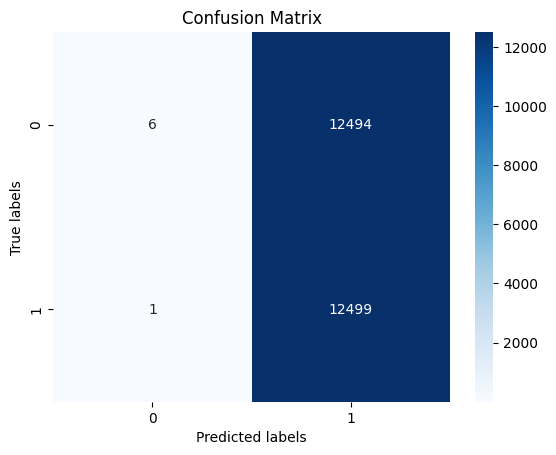

'Finished!'

In [147]:
(pos_train, neg_train, vocab) = load_training_set(0.1, 0.5)
(pos_test,  neg_test) = load_test_set(1, 1)
print(f"Length of pos_train: {len(pos_train)}, Length of neg_train: {len(neg_train)}, Length of vocab: {len(vocab)}")
print(f"Length of pos_test: {len(pos_test)}, Length of neg_test: {len(neg_test)}")

naive_bayes_unbalanced_data = NaiveBayes(pos_train, neg_train, vocab, smallConst=0.00000001, prod_method=False, compute_laplace=True, alpha=10)
pos_class_predictions = [naive_bayes_unbalanced_data.classify(doc) for doc in pos_test]
neg_class_predictions = [naive_bayes_unbalanced_data.classify(doc) for doc in neg_test]

true_labels = ['pos' for _ in range(len(pos_test))] + ['neg' for _ in range(len(neg_test))]
predicted_labels = pos_class_predictions + neg_class_predictions
total_predictions = len(pos_test) + len(neg_test)

true_pos = sum([1 for i in pos_class_predictions if i == 'pos'])
true_neg = sum([1 for i in neg_class_predictions if i == 'neg'])
false_neg = sum([1 for i in pos_class_predictions if i == 'neg'])
false_pos = sum([1 for i in neg_class_predictions if i == 'pos'])

conf_mat = np.array([np.array([true_pos, false_neg]), np.array([false_pos, true_neg])])
print(f'True Positives: {true_pos}, False Negatives: {false_neg}, False Positives: {false_pos}, True Negatives: {true_neg}')

accuracy = (true_pos + true_neg) / total_predictions
precision = true_pos / (true_pos + false_pos) if true_pos + false_pos != 0 else 0
recall = true_pos / (true_pos + false_neg) if true_pos + false_neg != 0 else 0

print("Confusion matrix for the unbalanced data model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# conf_mat = confusion_matrix(true_labels, predicted_labels)
print(conf_mat)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

"""Finished!"""